# 1.7.03 Epipolar Geometry

<h3>
    <ul>
        <li>We will learn about the basics of multiview geometry.</li>
        <li>We will see what epipole, epipolar lines, epipolar constraint etc.</li>
    </ul>
    </h3>
    

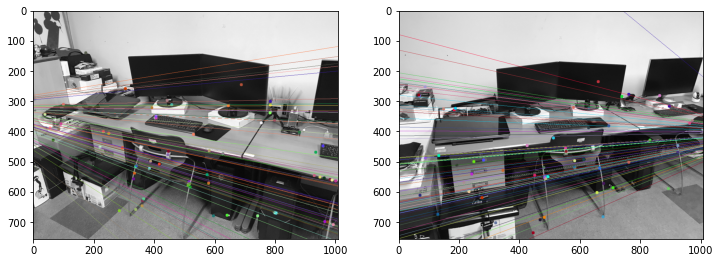

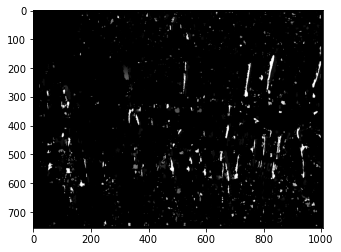

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('myleft.jpg', 0)
img2 = cv2.imread('myright.jpg', 0)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
pts1 = []
pts2 = []

for i, (m,n) in enumerate(matches) :
    if m.distance < 0.8*n.distance :
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)


pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

def drawlines(img1, img2, lines, pts1, pts2) :
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    
    for r, pt1, pt2 in zip(lines, pts1, pts2) :
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 - cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
        
    return img1, img2

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(12, 8))
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img1, img2)
plt.imshow(disparity, 'gray')
plt.show()